In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2024-10-26 08:46:42.368531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 08:46:42.377449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 08:46:42.380126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1729932403.348311  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932403.372795  125945 cuda_executor.cc:1015] succ

## learnMSA demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

## Run learnMSA from Python (Training + Viterbi alignment)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

I0000 00:00:1729932410.167175  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932410.167388  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932410.167507  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932410.167661  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1729932413.576143  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932413.576355  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932413.576470  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932413.576616  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 34s - 986ms/step - loss: 96.9187 - loglik: -8.3550e+01 - prior: -1.3369e+01 - aux_loss: 0.0000e+00
Epoch 2/10
34/34 - 3s - 85ms/step - loss: 70.1240 - loglik: -6.7555e+01 - prior: -2.5693e+00 - aux_loss: 0.0000e+00
Epoch 3/10
34/34 - 3s - 84ms/step - loss: 68.5832 - loglik: -6.6597e+01 - prior: -1.9864e+00 - aux_loss: 0.0000e+00
Epoch 4/10
34/34 - 3s - 85ms/step - loss: 68.2843 - loglik: -6.6462e+01 - prior: -1.8221e+00 - aux_loss: 0.0000e+00
Epoch 5/10
34/34 - 3s - 85ms/step - loss: 68.1124 - loglik: -6.6340e+01 - prior: -1.7720e+00 - aux_loss: 0.0000e+00
Epoch 6/10
34/34 - 3s - 83ms/step - loss: 68.0776 - loglik: -6.6343e+01 - prior: -1.7349e+00 - aux_loss: 0.0000e+00
Epoch 7/10
34/34 - 3s - 88ms/step - loss: 68.0629 - loglik: -6.6359e+01 - prior: -1.7038e+00 - aux_loss: 0.0000e+00
Epoch 8/10
34/34 - 3s - 84ms/step - loss: 67.9757 - loglik: -6.6292e+01 - prior: -1.6833e+00 - aux_loss: 0.0000e+00
Epoch 9/10
34/34 - 3s - 89ms/step - loss: 67.9654 - loglik: -6.6305e+01 - prior: 

I0000 00:00:1729932475.398142  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932475.398342  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932475.398460  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932475.398610  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 7), (15, 2), (17, 2)]
discards model 0: []
expansions model 1: [(12, 2), (13, 3), (14, 1), (17, 2), (19, 2)]
discards model 1: []
expansions model 2: [(12, 2), (13, 3), (18, 2), (20, 2)]
discards model 2: []
expansions model 3: [(12, 2), (13, 3), (16, 1), (17, 1)]
discards model 3: []
expansions model 4: [(12, 4), (13, 2), (16, 2), (18, 2)]
discards model 4: []
expansions model 5: [(12, 2), (13, 2), (15, 1), (18, 1)]
discards model 5: []
expansions model 6: [(12, 7), (15, 2), (17, 2)]
discards model 6: []
expansions model 7: [(12, 2), (13, 3), (14, 1), (17, 2), (19, 2)]
discards model 7: []
expansions model 8: [(12, 2), (13, 2), (15, 2), (18, 2)]
discards model 8: []
expansions model 9: [(12, 2), (13, 3), (14, 1), (17, 2), (19, 2)]
discards model 9: []
Re-initialized the encoder parameters.
Fitting models of lengths [34, 35, 35, 33, 34, 33, 34, 35, 35, 35] on 7774 sequences.
Batch size= 256 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.07

I0000 00:00:1729932480.953776  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932480.953977  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932480.954097  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932480.954248  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/2


I0000 00:00:1729932484.066381  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932484.066590  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932484.066721  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932484.066873  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 33s - 962ms/step - loss: 76.8065 - loglik: -6.4136e+01 - prior: -1.2670e+01 - aux_loss: 0.0000e+00
Epoch 2/2
34/34 - 3s - 86ms/step - loss: 65.4079 - loglik: -6.3203e+01 - prior: -2.2051e+00 - aux_loss: 0.0000e+00


I0000 00:00:1729932521.514774  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932521.514979  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932521.515093  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932521.515239  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: [16 22 26]
expansions model 1: []
discards model 1: [12 17 23 27]
expansions model 2: []
discards model 2: [12 15 23 27]
expansions model 3: []
discards model 3: [12 15]
expansions model 4: []
discards model 4: [17 22 26]
expansions model 5: []
discards model 5: [13 15]
expansions model 6: []
discards model 6: [16 22 26]
expansions model 7: []
discards model 7: [12 23 27]
expansions model 8: []
discards model 8: [12 17 19 24]
expansions model 9: []
discards model 9: [12 15 23 27]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31, 31, 31, 31, 32, 31, 31] on 7774 sequences.
Batch size= 256 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1729932528.136796  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932528.137015  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932528.137132  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932528.137279  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/2


I0000 00:00:1729932531.096218  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932531.096440  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932531.096554  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932531.096699  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 32s - 930ms/step - loss: 73.9188 - loglik: -6.2312e+01 - prior: -1.1607e+01 - aux_loss: 0.0000e+00
Epoch 2/2
34/34 - 3s - 85ms/step - loss: 64.8848 - loglik: -6.3216e+01 - prior: -1.6687e+00 - aux_loss: 0.0000e+00


I0000 00:00:1729932569.227425  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932569.227662  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932569.227789  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932569.227937  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: []
expansions model 1: []
discards model 1: []
expansions model 2: []
discards model 2: []
expansions model 3: []
discards model 3: []
expansions model 4: []
discards model 4: []
expansions model 5: []
discards model 5: []
expansions model 6: []
discards model 6: []
expansions model 7: []
discards model 7: [15]
expansions model 8: []
discards model 8: []
expansions model 9: []
discards model 9: []
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31, 31, 31, 31, 31, 31, 31] on 7774 sequences.
Batch size= 256 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1729932574.963900  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932574.964138  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932574.964254  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932574.964401  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1729932577.919560  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932577.919787  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932577.919901  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932577.920048  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 32s - 933ms/step - loss: 74.5883 - loglik: -6.2288e+01 - prior: -1.2300e+01 - aux_loss: 0.0000e+00
Epoch 2/10
34/34 - 3s - 85ms/step - loss: 64.6915 - loglik: -6.3014e+01 - prior: -1.6774e+00 - aux_loss: 0.0000e+00
Epoch 3/10
34/34 - 3s - 84ms/step - loss: 64.1928 - loglik: -6.3320e+01 - prior: -8.7283e-01 - aux_loss: 0.0000e+00
Epoch 4/10
34/34 - 3s - 80ms/step - loss: 63.9994 - loglik: -6.3318e+01 - prior: -6.8096e-01 - aux_loss: 0.0000e+00
Epoch 5/10
34/34 - 3s - 84ms/step - loss: 63.8700 - loglik: -6.3263e+01 - prior: -6.0655e-01 - aux_loss: 0.0000e+00
Epoch 6/10
34/34 - 3s - 85ms/step - loss: 63.7635 - loglik: -6.3216e+01 - prior: -5.4788e-01 - aux_loss: 0.0000e+00
Epoch 7/10
34/34 - 3s - 83ms/step - loss: 63.6628 - loglik: -6.3154e+01 - prior: -5.0855e-01 - aux_loss: 0.0000e+00
Epoch 8/10
34/34 - 3s - 84ms/step - loss: 63.7085 - loglik: -6.3226e+01 - prior: -4.8292e-01 - aux_loss: 0.0000e+00
Time for alignment: 221.3384
Likelihoods:  ['-59.0847', '-58.9633', '-59.0479', '

I0000 00:00:1729932638.755992  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932638.756202  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932638.756317  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932638.756465  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 2.3630
Wrote file test/data/interactive.alignment.fasta
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step
>l=-54.36_t=0.01
............$C....D....P........N............P........CYN.HG..T..C....S......................L......RA...T....G..........YTCSCL....PR......YT....GEH$.......................
>l=-56.73_t=0.01
............$C....D....S........Q............P........CRN.-G..T..Cs...L......................N......TN...T....D..........YTCACF....PG......YT....GRY$.......................
>l=-49.82_t=0.00
............$C....D....S........D............P........CLN.GG..T..C....T......................L......RSl..D....S..........YSCACA....PG......YT....GQH$.......................
>l=-63.07_t=0.01
............$C....D....H........V............T........CLN.GG..T..C....Q......................Lk.....TL...E....D..........YTCACA....NG......YT....GER$.......................
>l=-63.62_t=0.00
............$C....D....H........V............T........CLN.GG..T..C....Q......................Lk..

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1729932653.899153  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932653.899318  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729932653.899434  125945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but 

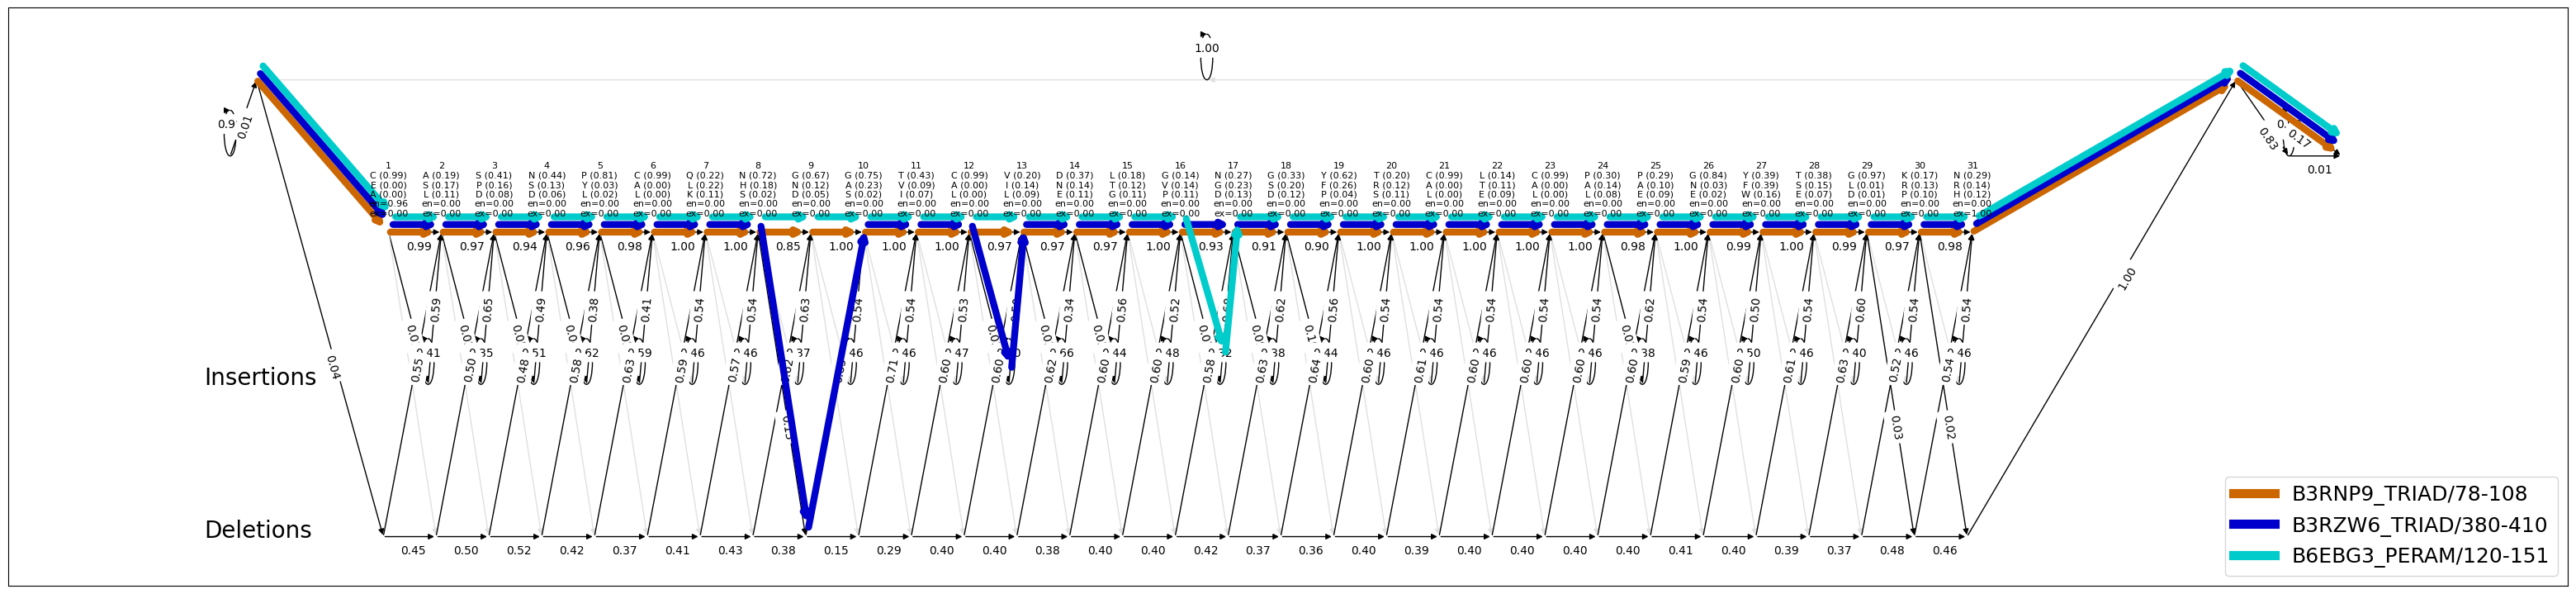

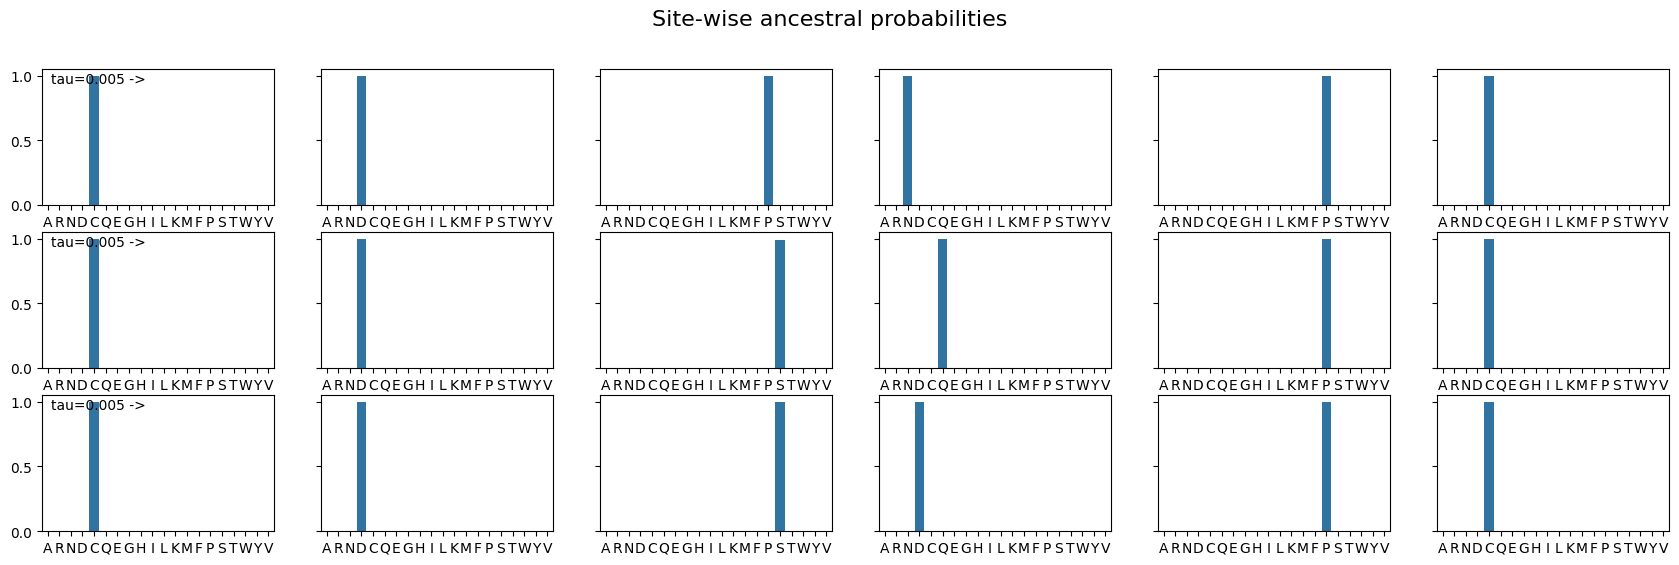

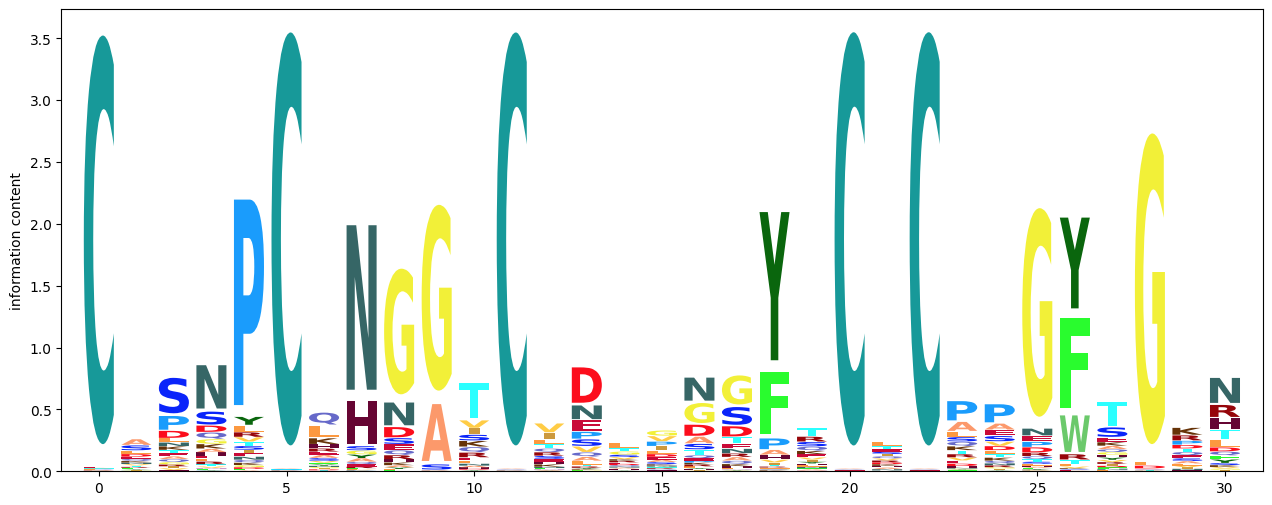

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = Configuration.make_default(num_models)
#config["batch_size"] = 128
with SequenceDataset(train_filename, fmt="fasta") as data:
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        sequence_weights=Align.compute_sequence_weights(train_filename, "tmp") if use_weights else None,
                                        verbose=True,
                                        align_insertions=align_insertions)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [4]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [5]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    79.3 [100.0]   [ 5182]
